# GRU model evalutation exploration, updates
#### 5/3/18



## Introduction - the data and the model
Below is a simple evaluation of a stacked GRU (gated recurrent unit) neural network. GRU's are a flavor of recurrent neural network that, similar to LSTM's, use a gating method to help prevent gradients from exploding or vanishing. They're seen as slightly simpler versions of LSTM's.

Given that mapping nucleosome positions is not an *exact* science, I've taken the **unique map** from the Widom/Wang 2012 paper and padded the proposed nucleosome centers from the unique map dataset with $\pm 10$ "1's" on either side of the claimed centers. This changes the interpretation of the binary 0/1 nucleosome occupancy vector into "there is probably a nucleosome located near this position." This *padding* was in an effort to turn the highly-sparse problem of predicting nucleosome occupancy to an easier, "nearby" problem.

The GRU was trained as a *stateful* and *bidirectional* recurrent neural network. The statefulness means that, between training batches (in neural network training, it's typical to train models using batches because entire pass-throughs of datasets to learn gradients is too time consuming), the internal state of the network is **not** reset. By bidirectional, this means that each GRU layer learns by feeding the DNA base pair sequences forward, and then a duplicate layer is added that learns by feeding the DNA base pair sequences backwards - the results of training both layers are concatenated and fed into the layer's activation function.

In this way, the model is set up to learn like this:

1. Scan 1000 consecutive base positions. Attempt to learn the corresponding 1000 binary 0/1 "nucleosome occupancy" labels. The problem is therefore a "multilabel" problem. That is - there are 1000 things to label, none of them being mutually exclusive (as opposed to a traditional multi-class classification problem).
2. Move forward to the next 1000 base positions. Repeat 1. Do not reset the internal state of the GRU until a user-defined number of batches have been trained on.

The batch size was 128, and 100 batches were considered one epoch. The model was trained for 300 epochs. Training loss, defined by binary cross-entropy loss, decreased from an initial value of 0.4 to 0.23 during the training process.

The chromosomes used to train the model were Chr I - V.

In [1]:
import os
import sys
import numpy as np
import pprint
import pickle as pkl
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getenv('HOME')
                             , 'nu'
                             , 'jiping_research'
                             , 'nuclstm'
                             , 'nuclstm'))

from keras.models import load_model
from loaders import *
from train import *
from utils import *
from preprocessors import *
from evaluation import *

Using TensorFlow backend.


In [19]:
data_dir = os.path.join(os.getenv('HOME'), 'nu/jiping_research/data')
data_file = 'seq_ncp_positions_unique_map.feather'
# config_file = '../nuclstm/model_configs/gru_binary_sequence_config.json'
config_file = '../model_output/gru_binary_sequence__050518_163831/gru_binary_sequence_config.json'
# model_dir = '../model_output/gru_binary_sequence__050218_134216/'
model_dir = '../model_output/gru_binary_sequence__050518_163831'

train_chroms = [1, 2, 3, 4, 5]
test_chroms = [7, 8]
all_chroms = train_chroms + test_chroms

loader = NcpLoader(data_dir)
nuc_df = loader.load(data_file
                     , chromosomes=all_chroms)

params = ConfigLoader(config_file).load()

print('Model configuration:')
pprint.pprint(params)
# m = load_model(os.path.join(model_dir, 'model_epoch_290.h5'))
m = load_model(os.path.join(model_dir, 'model_epoch_7104.h5'))

print('\n\nModel architecture:')
m.summary()

Model configuration:
{'data_params': {'batch_size': 128,
                 'lookback': 100,
                 'no_one_class_samples': False,
                 'output_len': 100,
                 'shuffle': False,
                 'step_size': 100,
                 'target_position': 'all'},
 'model_params': {'class_weight': None,
                  'dense_params': {'activation': 'sigmoid',
                                   'hidden_units': 1,
                                   'timedistributed': True},
                  'epochs': 5000,
                  'final_layer_activation': 'sigmoid',
                  'rnn_params': {'activation': 'tanh',
                                 'bidirectional': True,
                                 'flavor': 'gru',
                                 'hidden_units': [64, 32],
                                 'stateful': True},
                  'steps_per_epoch': 30,
                  'target': 'nucleosome',
                  'validation_steps': 10,
          

Text(0.5,0,'Chr I base index')

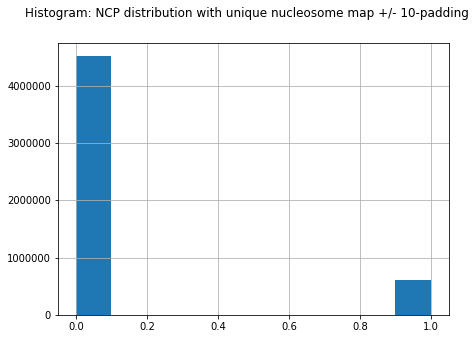

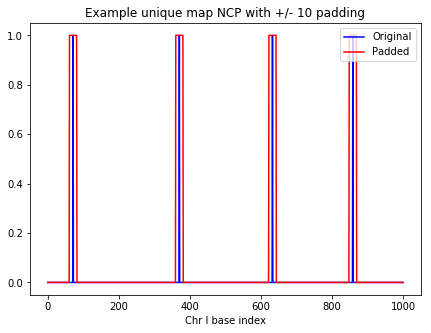

In [11]:
nuc_df = preprocess_by_chromosome(nuc_df
                                  , target=params['model_params']['target']
                                  , method=params['preprocessor_params']['target']['method']
                                  , pad_len=params['preprocessor_params']['target']['pad_len'])
TARGET = 'nucleosome_padded'

# plot distribution of padded NCP map
nuc_df[TARGET].hist(figsize=(7, 5))
plt.suptitle('Histogram: NCP distribution with unique nucleosome map +/- 10-padding')

# plot original NCP map and padded map
fig = plt.figure(figsize=(7, 5))
plt.plot(np.arange(0, 1000), nuc_df['nucleosome'].iloc[0:1000], 'b-', label='Original')
plt.plot(np.arange(0, 1000, ), nuc_df[TARGET].iloc[0:1000], 'r-', label='Padded')
plt.title('Example unique map NCP with +/- 10 padding')
plt.legend(loc='upper right')
plt.xlabel('Chr I base index')

Text(0.5,1,'Training accuracy over epochs')

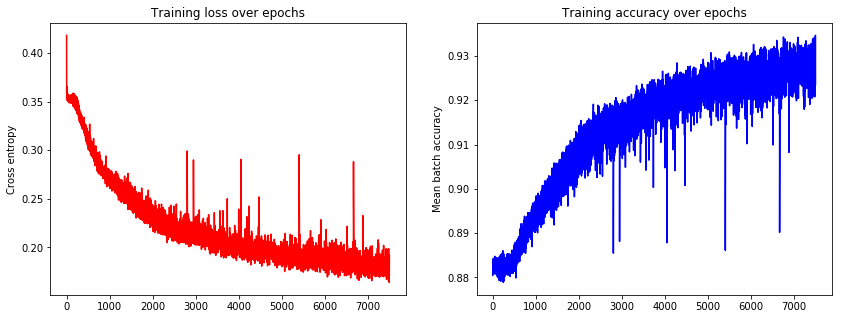

In [12]:
# Plot model diagnostics during training.
# with open(os.path.join(model_dir, 'model_history.pkl'), "rb") as f:
with open(os.path.join(model_dir, 'model_dat.pkl'), 'rb') as f:
#     model_history = pkl.load(f)
    model_history = pkl.load(f)['history']
    
n_epoch = len(model_history['loss'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(np.arange(1, n_epoch + 1), model_history['loss'], 'r-')
axes[0].set_ylabel('Cross entropy')
axes[0].set_title('Training loss over epochs')
axes[1].plot(np.arange(1, n_epoch + 1), model_history['acc'], 'b-')
axes[1].set_ylabel('Mean batch accuracy')
axes[1].set_title('Training accuracy over epochs')

## Evaluation: performance on a held-out chromosome - Chr VII and VIII

In the code below, we iterate over 10 batches of data from a hold-out chromosome. Each batch contains 128 consecutive 1000-base scans of the chromosome, and each scan is run through the model. So, each scan results in predicted probabilities for 1000 base positions. 100 batches will give us 10 x 128 x 1000 = 1,280,000 base index positions. Again, the output is on a probability scale.

We can evaluate this model using traditional binary classification metrics such as ROC AUC, precision and recall, etc., in addition to simply plotting predicted probability and actual 0/1 nucleosome position occupancy as a function of base position. The plots below are randomly sampled sections across chromosomes VII and VIII with their predicted probability of NCP proximity.

In [13]:
# n_test_batches = 10
n_test_batches = 100

test_gen = gen_seq_scans(loader.subset_to_chromosomes(nuc_df, test_chroms)
                         , lookback=params['data_params']['lookback']
                         , batch_size=params['data_params']['batch_size']
                         , target=TARGET
                         , target_position=params['data_params']['target_position']
                         , shuffle=False
                         , step_size=params['data_params']['lookback']
                         , flatten_final_target_dim=False
                         , no_one_class_samples=False)

y_test, y_preds = extract_preds_from_generator(test_gen
                                               , model=m
                                               , n_batches=n_test_batches)

tab = np.unique(y_test, return_counts=True)
print('Test set composition:')
print(tab)

Test set composition:
(array([ 0.,  1.]), array([11290134,  1509866]))


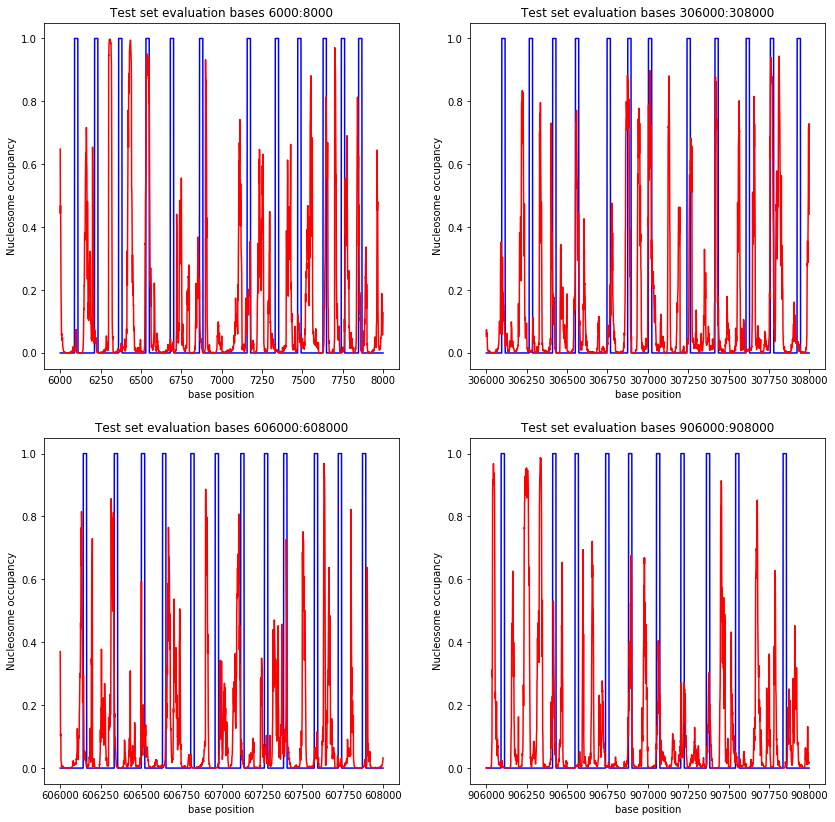

In [14]:
start = 6000
base_step = 300000

plot_genome_predictions(y_test
                        , preds=y_preds
                        , start=start
                        , base_step=base_step)

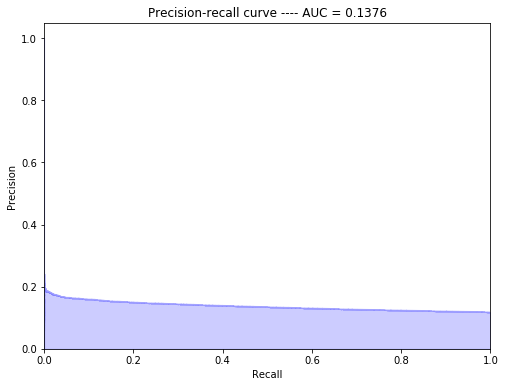

In [15]:
pr_plot(y_test
        , preds=y_preds
        , verbose=False)

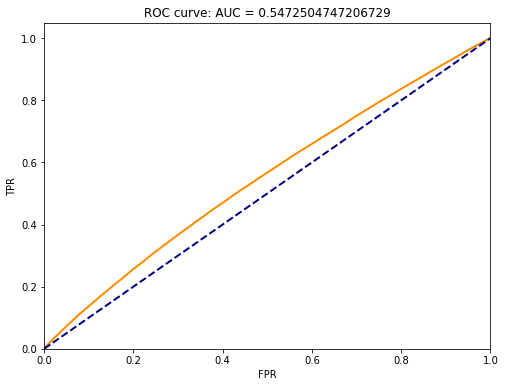

In [16]:
roc_plot(y_test
         , preds=y_preds
         , verbose=False)

## Summary, where to go next

Despite having driven cross entropy loss down significantly, the model is not responsive enough to the sharp structured nature of the NCP blocks (i.e. 21 1's, then period of 0's, then 21 1's, etc.). Predictions appear to do the best when there is a long period of no nucleosome centers, allowing the model time to "build up" to a high probability of the next nucleosome center.

The model has learned things - there is clearly the potential for the model to learn. It appears to generally predict 1's when there is a relatively dense period of nucleosome centers, e.g. in sections where consecutive linker lengths are short, and in stretches of long linkers, probability drops precipitously. The problem is that the model doesn't move quickly enough. It needs to become more responsive to the structure of the NCP blocks - predicted probability needs to be more responsive to changes in nucleosome occupancy. Therefore, I'm going to try using a different scan length - probably on the order of ~100, but continue to use the stateful RNN so that learned parameter settings can continue across scans.